In [3]:
##Libraries to be imported 
import pandas as pd 
import numpy as np 
from sklearn.metrics import confusion_matrix,roc_auc_score, mean_squared_error,classification_report,roc_curve,accuracy_score,precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
import xgboost as xgb

In [4]:
##Data to be used
data = pd.read_csv('forModel.csv')
data.drop(['Checkup','Unnamed: 0.1','Unnamed: 0'], axis = 1, inplace =True)

##Cloned Data 
clonedData = pd.read_csv('forModel.csv')
clonedData['Heart_Disease'] = clonedData['Heart_Disease'].map({'Yes':1,'No':0})
data.head(5)


,General_Health,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption,SexBinary
0,Very Good,Yes,No,No,No,No,No,Yes,Female,55-59,170.0,68.04,23.49,No,0.0,90.0,4.0,1.0,0
1,Excellent,No,No,No,No,No,No,No,Female,80+,168.0,77.11,27.44,Yes,30.0,2.0,30.0,0.0,0
2,Good,Yes,No,Yes,No,No,No,Yes,Female,80+,175.0,72.57,23.63,No,0.0,60.0,20.0,1.0,0
3,Very Good,Yes,No,No,No,No,No,No,Male,55-59,180.0,99.79,30.68,No,20.0,30.0,16.0,4.0,1
4,Good,Yes,No,No,No,No,No,Yes,Male,30-34,188.0,70.31,19.90,Yes,24.0,8.0,24.0,20.0,1


### Model Preparation ! 
---

In [5]:
## lets first evaluate the datas that we will be using ! 

print(f"The data has {data.shape[0]} rows and {data.shape[1]} columns")
print(data.dtypes)

The data has 160000 rows and 19 columns
General_Health                   object
Exercise                         object
Heart_Disease                    object
Skin_Cancer                      object
Other_Cancer                     object
Depression                       object
Diabetes                         object
Arthritis                        object
Sex                              object
Age_Category                     object
Height_(cm)                     float64
Weight_(kg)                     float64
BMI                             float64
Smoking_History                  object
Alcohol_Consumption             float64
Fruit_Consumption               float64
Green_Vegetables_Consumption    float64
FriedPotato_Consumption         float64
SexBinary                         int64
dtype: object


---
### Feature Engineering 

In [6]:
## Lets convert few columns in order to create few 
##Lets use the One Hot Encoder to change all the categorical data into the numerical datatypes 
onlyCategorical = data.select_dtypes("object")
for everything in onlyCategorical.columns:
    print(f"The number of unique features that the columns {everything} has is {data[everything].nunique()}")


The number of unique features that the columns General_Health has is 5
The number of unique features that the columns Exercise has is 2
The number of unique features that the columns Heart_Disease has is 2
The number of unique features that the columns Skin_Cancer has is 2
The number of unique features that the columns Other_Cancer has is 2
The number of unique features that the columns Depression has is 2
The number of unique features that the columns Diabetes has is 4
The number of unique features that the columns Arthritis has is 2
The number of unique features that the columns Sex has is 2
The number of unique features that the columns Age_Category has is 13
The number of unique features that the columns Smoking_History has is 2


In [7]:
## As seen lets convert the binary category using the .map and nominal category using the onehotencoding 
data['General_Health'] = data['General_Health'].apply(lambda x: 'Poor' if x == 'Poor' else 'Good')
data['General_Health'] = data['General_Health'].map({"Poor":1, "Good":0})
data['Sex'] = data['Sex'].map({'Male':1, 'Female':0})
data['Diabetes'] = data['Diabetes'].apply(lambda x:'No' if x == 'No' else 'Yes')
## Since most of the Binary have Yes and No we will convert all of them at once 
cols = ['Exercise','Heart_Disease','Skin_Cancer','Other_Cancer','Depression','Arthritis','Smoking_History','Diabetes']
for each in cols:
    data[each] = data[each].map({'Yes':1,'No':0}) ##This converts the whole data into the binary 

dummied_data = pd.get_dummies(data, columns=['Age_Category'], dtype = 'int')




### The reason to convert the binary categories using the .map instead of using OneHotEncoding is to minimize the number of columns. 

---

In [8]:
## Lets figure out the independent variable and dependent varibale 
SEED = 9
X = dummied_data.drop('Heart_Disease', axis = 1)
y = clonedData['Heart_Disease']
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.2, random_state = SEED)
print(X.columns)


Index(['General_Health', 'Exercise', 'Skin_Cancer', 'Other_Cancer',
       'Depression', 'Diabetes', 'Arthritis', 'Sex', 'Height_(cm)',
       'Weight_(kg)', 'BMI', 'Smoking_History', 'Alcohol_Consumption',
       'Fruit_Consumption', 'Green_Vegetables_Consumption',
       'FriedPotato_Consumption', 'SexBinary', 'Age_Category_18-24',
       'Age_Category_25-29', 'Age_Category_30-34', 'Age_Category_35-39',
       'Age_Category_40-44', 'Age_Category_45-49', 'Age_Category_50-54',
       'Age_Category_55-59', 'Age_Category_60-64', 'Age_Category_65-69',
       'Age_Category_70-74', 'Age_Category_75-79', 'Age_Category_80+'],
      dtype='object')


### We will be selecting the best models among the LogisticRegression, DecisionTreeClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifer, GradientBoostClassifer through its ROC_AUC_SCORE and other different parameters

---
### Model One : Logistic Regression

In [9]:
##Pipeline Preparation 
pipeline_steps = [('imputer',SimpleImputer(strategy='median')),('scalar',StandardScaler()),('logit',LogisticRegression(solver='liblinear',max_iter=1000))]
logit_pipeline = Pipeline(pipeline_steps)

##Lets do the hyperparameer tuining 
params = {'logit__C':[0.01,0.1],'logit__penalty':['l1','l2']}
hyper_tuning = RandomizedSearchCV(logit_pipeline, param_distributions= params, cv = 3, n_jobs=-1, n_iter=4) ## The best parameter has been calcuated and updated accordingly in the logit_model 
hyper_tuning.fit(X_train,y_train)
hyper_tuned_model = hyper_tuning.best_estimator_
training_predict = hyper_tuned_model.predict(X_train)
testing_predict = hyper_tuned_model.predict(X_test)
probabilites_predict = hyper_tuned_model.predict_proba(X_test)[:,1]
logit_training_score = accuracy_score(y_train,training_predict) #0.74

logit_testing_score = accuracy_score(y_test,testing_predict) #0.74
## classification report 
class_report_logit = classification_report(y_test, testing_predict)
##ROC AUC score 
logit_fpr, logit_tpr, logit_thresholds = roc_curve(y_test,probabilites_predict)
logit_roc_score = roc_auc_score(y_test,probabilites_predict) ##81%
print(class_report_logit)

## Precision recall values 
logit_precision, logit_recall , logit_thresholds = precision_recall_curve(y_test,probabilites_predict)


              precision    recall  f1-score   support

           0       0.76      0.71      0.73     15927
           1       0.73      0.77      0.75     16073

    accuracy                           0.74     32000
   macro avg       0.74      0.74      0.74     32000
weighted avg       0.74      0.74      0.74     32000



### The logistic regression model has 76% precision, 71%recall, and 73% f1-score. Whereas, the training and testing score is equaivalent(~74%) which means the model has no problem with over fitting and underfitting. Also, the roc score of the model is 81% which is good 
---


### Model Two: Decision Tree Classifier 

In [10]:
## Pipeline Preparation 
decision_steps = [('Imputer',SimpleImputer(strategy='median')),('Scalar',StandardScaler()),('DecisionTree',DecisionTreeClassifier(random_state=SEED, class_weight='balanced'))] ## This is the pipeline we will be using 
decision_pipeline = Pipeline(decision_steps)
#cross validation 
params = {'DecisionTree__max_depth':[3,4,5,6,7], 'DecisionTree__max_features':['sqrt','log2',None, 0.5]}
cross_validation = cross_val_score(decision_pipeline, X,y, cv=5, scoring='roc_auc')
#Hyperparameter tuning
decision_hyper_tuning = RandomizedSearchCV(decision_pipeline, param_distributions=params, cv = 5, n_jobs = -1, n_iter = 20)
decision_hyper_tuning.fit(X_train,y_train)
best_decision_model = decision_hyper_tuning.best_estimator_
decision_training_predict = best_decision_model.predict(X_train) #predicting the training accuracy 
decision_testing_predict = best_decision_model.predict(X_test) #prediciting the testing accuracy
decision_predicited_proba = best_decision_model.predict_proba(X_test)[:,1] 
decision_testing_accuracy_score = accuracy_score(y_test, decision_testing_predict) # Testing Accuracy -> 0.72
decision_training_accuracy_score = accuracy_score(y_train, decision_training_predict) # Training Accuracy -> 0.72

##Classification report -> Analysis of precision, recall and f1 score
decision_classification = classification_report(y_test, decision_testing_predict)
decision_fpr, decision_tpr, decision_thresholds = roc_curve(y_test, decision_predicited_proba)
decision_roc_score = roc_auc_score(y_test, decision_predicited_proba) ## 0.78

print(decision_classification)

## Precision recall values 
decision_precision, decision_recall , decision_thresholds = precision_recall_curve(y_test,decision_predicited_proba)

              precision    recall  f1-score   support

           0       0.75      0.67      0.71     15927
           1       0.70      0.78      0.74     16073

    accuracy                           0.72     32000
   macro avg       0.73      0.72      0.72     32000
weighted avg       0.73      0.72      0.72     32000



### The Decision Tree Classifier model has 75% precision, 67%recall, and 71% f1-score. Whereas, the training and testing score is equaivalent(~72%) which means the model has no problem with over fitting and underfitting. Also, the roc score of the model is 78%
---


## Model Three: Bagging Classifier 

In [11]:
## Pipeline Preparation 
decision_steps = [("imputer",SimpleImputer(strategy='median')),("DecisionTree",DecisionTreeClassifier(random_state=SEED))]
decision_pipeline = Pipeline(decision_steps)
params = params = {
    "DecisionTree__max_depth": np.arange(3, 15),
    "DecisionTree__min_samples_leaf": [1, 2, 5, 10],
    "DecisionTree__class_weight": [None, "balanced"]
}
best_tuned_model = RandomizedSearchCV(decision_pipeline, param_distributions= params , cv = 5, n_jobs = -1)
best_tuned_model.fit(X_train,y_train)
best_decision_params = best_tuned_model.best_estimator_ ## This is the hypertuned model prepared for the bagging classifier 
bagging_classifier = BaggingClassifier(estimator=best_decision_params, n_estimators=50,bootstrap=True) ## Dervied from Randomized Search 
bagging_classifier.fit(X_train,y_train)

bagging_training_predict = bagging_classifier.predict(X_train) # Training Score -> 0.79 
bagging_testing_predict = bagging_classifier.predict(X_test) # Testing Score -> 0.84
bagging_predicted_proba = bagging_classifier.predict_proba(X_test)[:,1]
print(accuracy_score(y_test, bagging_testing_predict)) ## Testing Score 
print(accuracy_score(y_train, bagging_training_predict)) ## Training Score

bagging_classification_report = classification_report(y_test, bagging_testing_predict)
print(bagging_classification_report)

bagging_fpr, bagging_tpr, bagging_thresholds = roc_curve(y_test, bagging_predicted_proba)
bagging_roc_auc_score = roc_auc_score(y_test, bagging_predicted_proba)

print(bagging_roc_auc_score) #0.87

## Precision Recall values 
bagging_precision, bagging_recall, bagging_thresholds = precision_recall_curve(y_test,bagging_predicted_proba)

### The Bagging Classifier with Decision Tree Classifier as base model has 83% precision, 75%recall, and 79% f1-score. Whereas, the training and testing score is 79% and 84% respectively which means the model has no problem with over fitting and underfitting. Also, the roc score of the model is 87%
---

### Model Four : Random Forest Classifier

In [ ]:
## Model Preparation 
decision_steps = [("imputer",SimpleImputer(strategy='median')),('randomForest',RandomForestClassifier(class_weight='balanced', random_state=SEED))]
random_forest_pipeline = Pipeline(decision_steps)

## cross validation 
random_cross_validation = cross_val_score(random_forest_pipeline, X, y , cv = 5, scoring = 'roc_auc')

#Hyper Parameter Tuning

params = {
    'randomForest__n_estimators': [50, 100, 150, 200],
    'randomForest__max_features': ['sqrt', 'log2', None, 0.33],
    'randomForest__max_depth': np.arange(5, 50, step=5),
    'randomForest__max_leaf_nodes': np.logspace(1, 3, num=5).astype(int),
    'randomForest__min_samples_split': [2, 5, 10],
    'randomForest__min_samples_leaf': [1, 2, 4],
    'randomForest__class_weight': [None, 'balanced']
}

random_hyper_tuned = RandomizedSearchCV(random_forest_pipeline, param_distributions=params, cv = 5, n_jobs = -1)
random_hyper_tuned.fit(X_train,y_train)
best_random_forest_model = random_hyper_tuned.best_estimator_
print(random_hyper_tuned.best_params_)

random_training_predicted = best_random_forest_model.predict(X_train)
random_testing_predicted = best_random_forest_model.predict(X_test)
random_predicted_proba = best_random_forest_model.predict_proba(X_test)[:,1]

random_testing_score = accuracy_score(y_test, random_testing_predicted)
random_training_score = accuracy_score(y_train, random_training_predicted)

print(random_testing_score,random_training_score)
random_classification_report = classification_report(y_test, random_testing_predicted)
print(random_classification_report)

random_fpr, random_tpr, random_thresholds = roc_curve(y_test, random_predicted_proba)
random_roc_auc_score = roc_auc_score(y_test, random_predicted_proba)
  
print(random_roc_auc_score)

## Precsion Recall Curve 
random_precision, random_recall, random_thresholds = precision_recall_curve(y_test,random_predicted_proba)


{'randomForest__n_estimators': 100, 'randomForest__min_samples_split': 5, 'randomForest__min_samples_leaf': 2, 'randomForest__max_leaf_nodes': np.int64(1000), 'randomForest__max_features': 0.33, 'randomForest__max_depth': np.int64(45), 'randomForest__class_weight': None}
0.7805 0.809234375
              precision    recall  f1-score   support

           0       0.82      0.71      0.76     15927
           1       0.75      0.85      0.79     16073

    accuracy                           0.78     32000
   macro avg       0.79      0.78      0.78     32000
weighted avg       0.79      0.78      0.78     32000

0.851603317164364


---
### Model Five: XGBoost Classifier (Using the Scikit-Learn API)

In [ ]:
## Model Preparation 
decision_steps = [("imputer",SimpleImputer()),("scalar",StandardScaler()),('xgb',xgb.XGBClassifier(random_state = SEED))]
xgb_model = Pipeline(decision_steps)

## Cross Validation 
params = {'xgb__max_depth':[3,4,5,6,7],'xgb__n_estimators':[100,150,200],'xgb__subsample':[0.1,0.2,0.3,0.4,0.5],'xgb__learning_rate':[0.02,0.05,0.1,0.2,0.3] }

xgb_cross_validation = cross_val_score(xgb_model, X,y, cv = 10, scoring='accuracy')

##Hyperparameter tuning
xgb_hyper_tuned = RandomizedSearchCV(xgb_model,param_distributions=params, cv = 10, n_jobs = -1)
xgb_hyper_tuned.fit(X_train,y_train)
best_xgb_model = xgb_hyper_tuned.best_estimator_

##Training and Testing Accuracy

xgb_training_prediction = best_xgb_model.predict(X_train)
xgb_testing_prediction = best_xgb_model.predict(X_test)
xgb_testing_probabilites = best_xgb_model.predict_proba(X_test)[:,1]

xgb_testing_score = accuracy_score(y_test, xgb_testing_prediction) #76 %
xgb_training_score = accuracy_score(y_train, xgb_training_prediction) #78 %

##ROC AUC SCORE 
xgb_fpr, xgb_tpr, xgb_threshold = roc_curve(y_test, xgb_testing_probabilites)
xgb_roc_auc_score = roc_auc_score(y_test, xgb_testing_probabilites)
print(xgb_roc_auc_score)

##Confusion Matrix

xgb_confusion_matrix = confusion_matrix(y_test, xgb_testing_prediction)

xgb_true_negatives = xgb_confusion_matrix[0][0]
xgb_false_positives = xgb_confusion_matrix[0][1]
xgb_false_negatives = xgb_confusion_matrix[1][0]
xgb_true_positives = xgb_confusion_matrix[1][1]


xgb_accuracy = (xgb_true_negatives+ xgb_true_positives)/(xgb_true_negatives+xgb_false_positives+xgb_false_negatives+xgb_true_positives)

xgb_precision = (xgb_true_positives)/(xgb_false_positives+xgb_true_positives)

xgb_recall = (xgb_true_positives)/(xgb_false_negatives+xgb_true_positives)

## Classification report 
xgb_classification_report = classification_report(y_test, xgb_testing_prediction)
print(xgb_classification_report)

##Precision Recall 
xgb_precision, xgb_recall, xgb_thresholds = precision_recall_curve(y_test, xgb_testing_probabilites)

0.865337939007332
              precision    recall  f1-score   support

           0       0.82      0.74      0.78     15927
           1       0.76      0.84      0.80     16073

    accuracy                           0.79     32000
   macro avg       0.79      0.79      0.79     32000
weighted avg       0.79      0.79      0.79     32000



---
### Evaluating the best Model 
### Metric 1 : ROC AUC CURVE


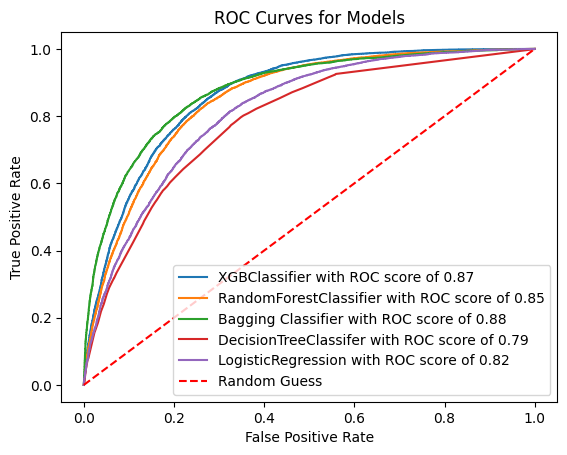

In [ ]:
plt.plot(xgb_fpr,xgb_tpr, label = f'XGBClassifier with ROC score of {xgb_roc_auc_score:.2f}')
plt.plot(random_fpr,random_tpr, label = f'RandomForestClassifier with ROC score of {random_roc_auc_score:.2f}')
plt.plot(bagging_fpr, bagging_tpr, label = f'Bagging Classifier with ROC score of {bagging_roc_auc_score:.2f}')
plt.plot(decision_fpr, decision_tpr, label = f'DecisionTreeClassifer with ROC score of {decision_roc_score:.2f}')
plt.plot(logit_fpr, logit_tpr, label = f'LogisticRegression with ROC score of {logit_roc_score:.2f}')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Models')
plt.legend()
plt.show()

---
### Precision-Recall Curve

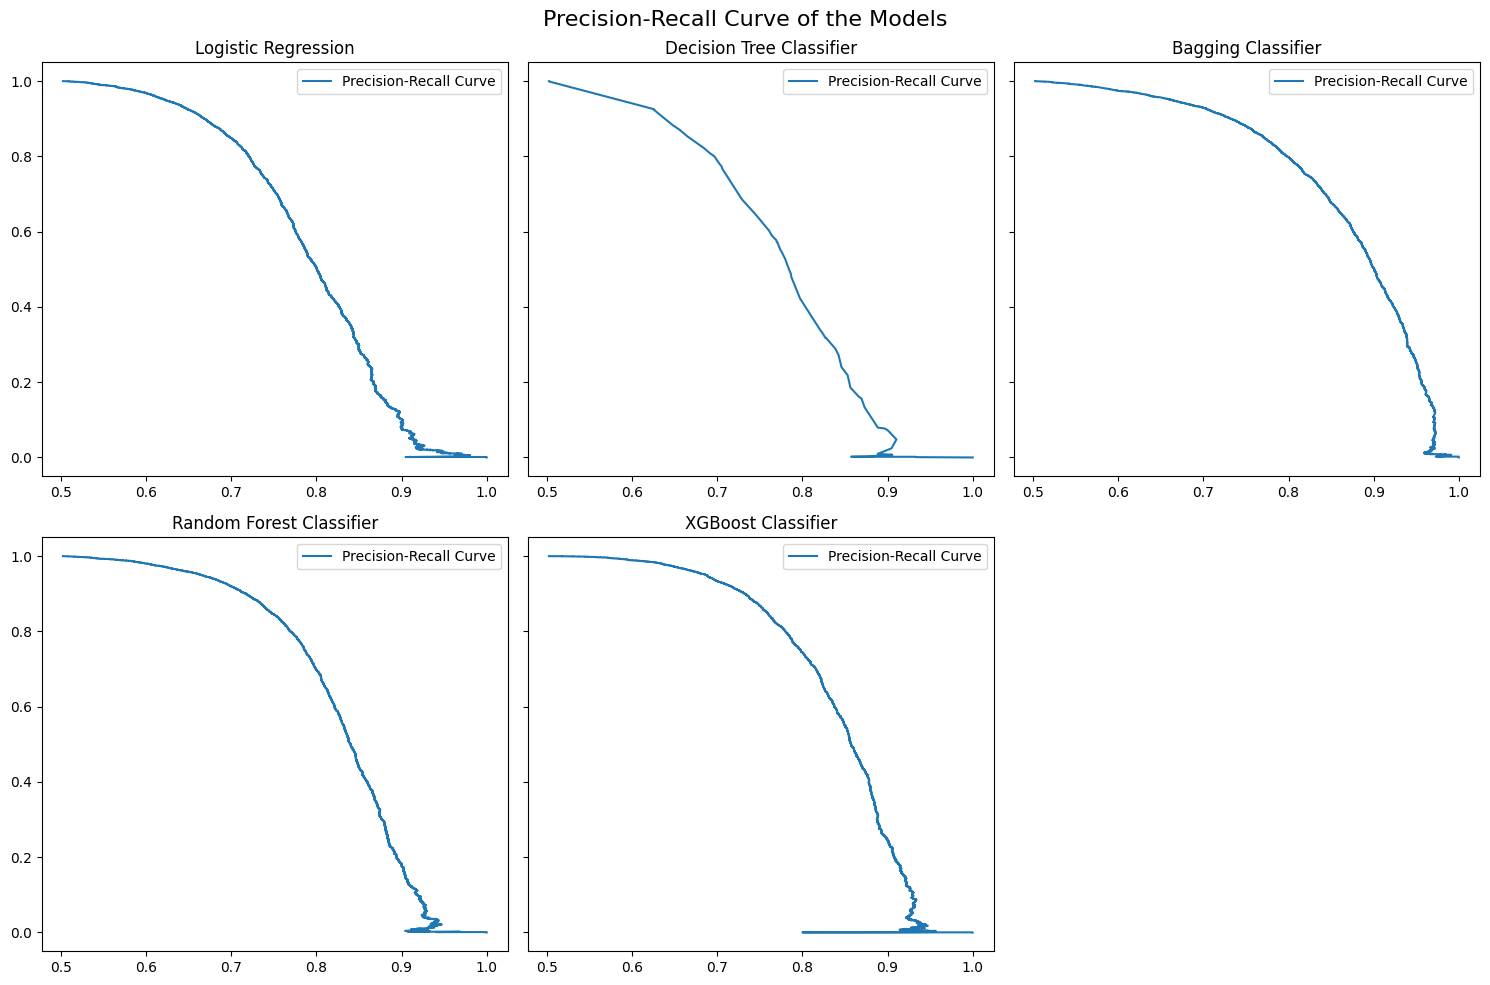

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10), sharey=True)

ax[0][0].plot(logit_precision, logit_recall)
ax[0][0].set_title("Logistic Regression")
ax[0][0].legend(["Precision-Recall Curve"])

ax[0][1].plot(decision_precision, decision_recall)
ax[0][1].set_title("Decision Tree Classifier")
ax[0][1].legend(["Precision-Recall Curve"])

ax[0][2].plot(bagging_precision, bagging_recall)
ax[0][2].set_title("Bagging Classifier")
ax[0][2].legend(["Precision-Recall Curve"])

ax[1][0].plot(random_precision, random_recall)
ax[1][0].set_title("Random Forest Classifier")
ax[1][0].legend(["Precision-Recall Curve"])

ax[1][1].plot(xgb_precision, xgb_recall)
ax[1][1].set_title("XGBoost Classifier")
ax[1][1].legend(["Precision-Recall Curve"])

# Optional: Hide the last empty subplot (bottom right corner)
fig.delaxes(ax[1][2])

plt.tight_layout()
plt.suptitle("Precision-Recall Curve of the Models", fontsize = 16)
plt.tight_layout()
plt.show()


### Based on the ROC AUC Score and precision recall curve I decide to go with the bagging classifier becuase it performs better in all metrics comparatively.

In [ ]:
## Model to be used! 
import pickle
with open("model.pkl", "wb") as f:
    pickle.dump(bagging_classifier, f)

---
### Go to the CARDIOVASCULAR PROJECT -> APP, to use the web app and see how risky are you to get the cardiovascular disease!
### *Sujal Adhikari*